In [1]:
# accessing to data 

path_training = 'BelgiumTSC_Training\Training'
path_testing = 'BelgiumTSC_Testing\Testing'

nbr_class = 62 # len(next(walk(path_training))[1])  counting the number of classes 
print('number of classes : ', nbr_class)

#-----------------------------------------------------------------------------

# resol is the format for the images that we want for convenience

resol = (40,30)

number of classes :  62


In [2]:
from glob2 import glob

def names (path) : 

    # Retrieving the names of all files finishing with .ppm or .jpeg in the mentionned Directory 
    # returns a list of string 

    names = glob(path + "\\**\\*.ppm") + glob(path + "\\**\\*.jpeg")
    return names

#-----------------------------------------------------------------------------

training_names = names(path_training) 
testing_names = names(path_testing)
print("number of images in the training folder : ", len(training_names))
print("number of images in the testing folder : ", len(testing_names))

number of images in the training folder :  4575
number of images in the testing folder :  2520


In [3]:
from PIL import Image 
from os.path import dirname, realpath, basename
from numpy import asarray, append, array
from matplotlib.pyplot import show, figure, imshow

# We'll store Images and categories in arrays for convenience 

X_train = []
y_train = []

X_test = []
y_test = [] 

#-----------------------------------------------------------------------------

def store_images(names, X_array, y_array) : 

    # We'll process each image 

    for i in range(len(names)):

        # We store the category 

        # dirname(realpath()) gives the current location of the name that we process 
        # basename gives the name of the upper directory which is the category that we must predict 
        y_array.append((float(basename(dirname(realpath(names[i]))))))

        # We open the image 
        img = Image.open(names[i])

        # We resize the image 
        img = img.resize((resol[1],resol[0]))

        # We store the image 
        img = asarray(img)

        X_array.append(img)

#-----------------------------------------------------------------------------

store_images(training_names, X_train, y_train)
store_images(testing_names, X_test, y_test)

X_test = array(X_test)
X_train = array(X_train)
y_test = array(y_test)
y_train = array(y_train)

print("Shape of X_train : ", X_train.shape)
print("Shape of y_train : ", y_train.shape)

print("Shape of X_train : ", X_test.shape)
print("Shape of y_train : ", y_test.shape)

Shape of X_train :  (4575, 40, 30, 3)
Shape of y_train :  (4575,)
Shape of X_train :  (2520, 40, 30, 3)
Shape of y_train :  (2520,)


In [4]:
from numpy import zeros

# This cell is about visualisation of the initial dataset 

initial_nbr_train = zeros(nbr_class, dtype=int)
initial_nbr_test = zeros(nbr_class, dtype=int)

for i in range(nbr_class) :
    initial_nbr_train[i] = int((y_train == i).sum())  # Number of images of class i in the Training set
    initial_nbr_test[i] = int((y_test == i).sum())   # Number of images of class i in the Test set 

In [5]:
from numpy import zeros, arange
from matplotlib.pyplot import subplots, title, xticks, legend, show

# This cell is about visualisation of the dataset

def graphs (nrb_train, y_train) : 

    #-----------------------------------------------------------------------------

    print("Number of each sign in the train set : ")
    print()
    print(nrb_train)
    print()
    print("Total of signs : ", nrb_train.sum())
    print()

    print("Number of each sign in the test set : ")
    print()
    print(initial_nbr_test)
    print()
    print("Total of signs : ", initial_nbr_test.sum())

    #-----------------------------------------------------------------------------

    # We plot an histo showing how many signs of each class we have in each set 

    fig, ax = subplots(figsize = (20, 7))
    bins = [x + 0.5 for x in range(-1, nbr_class)]
    ax.hist([y_train, y_test], range = (0, nbr_class-1), bins=bins, edgecolor = 'white', color = ['blueviolet','black'], label = ['y_train', 'y_test'])
    title("Visualisation of the number of signs of each class in each set")
    xticks(arange(nbr_class))
    legend()
    show()

Number of each sign in the train set : 

[ 15 110  13  15  15  11  18 157  27  18  21   7  18  90  43   9   9  79
  81 231  42  43 375  15  48  42   6  18 125  33  37  63 316  12  46  60
  18  98 285 196 242 148  35  30  48  74  44 147  11  12  15  27  27 199
 118  12  95  78  15  42   9 282]

Total of signs :  4575

Number of each sign in the test set : 

[  6  27   7   6  12   3   6  90  12   0  28   0   3  39  15   0  12 183
 122 163   3  45  61  15  13   3   0   9  51  28  37  86 422   0   9 154
   0  31 213  99  48  11   9   6   3  84   6  31   0   3   0   3   0  24
  48  15  33  41   9  17  11 105]

Total of signs :  2520


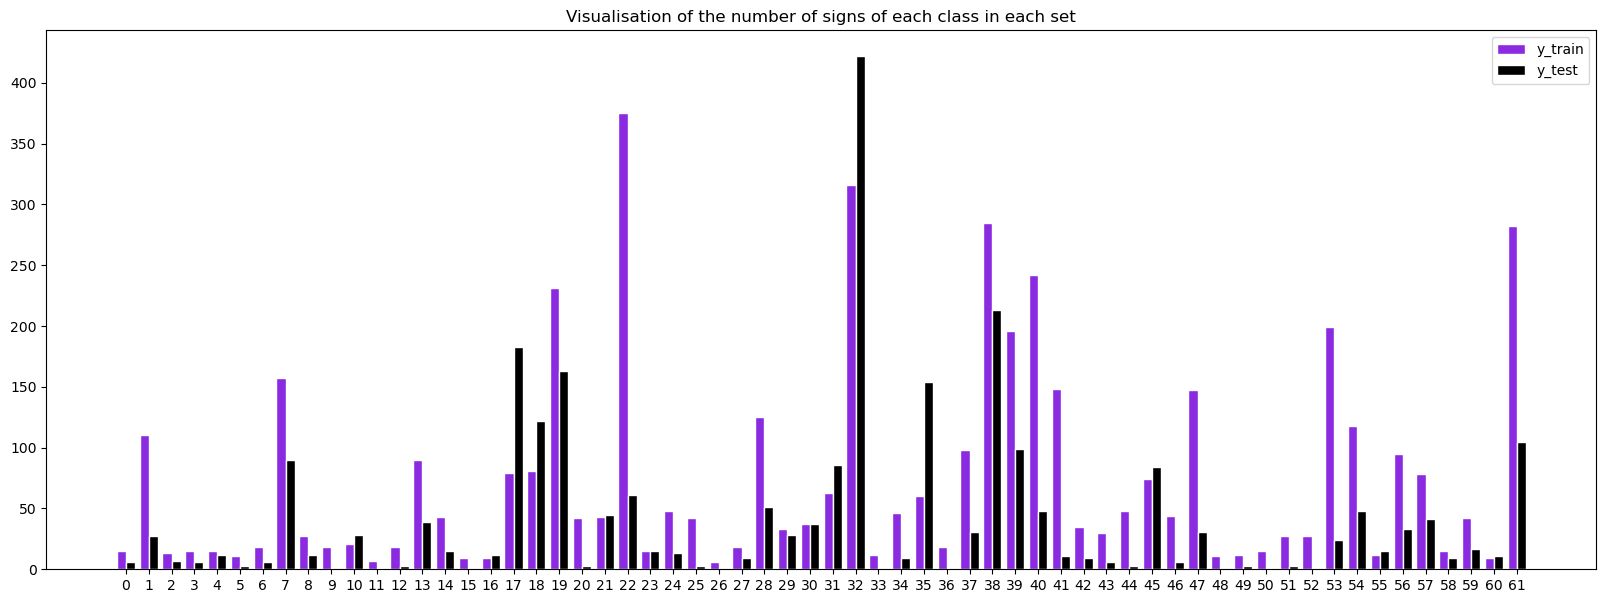

In [6]:
graphs(initial_nbr_train, y_train)

In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomFlip

# This cell is about data augmentation 
# We'll randomize our initial set and do our augmentation with this (cells later) 

#-----------------------------------------------------------------------------

data_augmentation = Sequential(
    [
        # First, we'll flip the images randomly 
        RandomFlip("horizontal", input_shape=(resol[0], resol[1], 3)),
        
        # Then, we rotate them randomly 
        RandomRotation(0.1),

        # We do random zooms 
        RandomZoom(0.2),

        # We finally change their orientation randomly 
        RandomFlip(mode="horizontal_and_vertical")
    ]
)

#-----------------------------------------------------------------------------

# We apply the augmentation on our datasets 
augmented_image_train = data_augmentation(X_train)
augmented_image_test = data_augmentation(X_test)

augmented_image_train = array(augmented_image_train)
augmented_image_test = array(augmented_image_test)

print("Shape of the randomized test set : ", augmented_image_test.shape)
print("Shape of the randomized training set : ", augmented_image_train.shape)

Shape of the randomized test set :  (2520, 40, 30, 3)
Shape of the randomized training set :  (4575, 40, 30, 3)


In [8]:
from numpy import zeros, where, abs
from tensorflow import gather
from random import randint

# First method of augmentation 
# If the training set has less than 3/4 of elements compared to the test set, we fill it with augmented images 

memory = zeros((nbr_class, 2), dtype=int)
counter_train = 0
counter_test = 0

#-----------------------------------------------------------------------------

for i in range(nbr_class) :
    
    if initial_nbr_train[i] < 3*initial_nbr_test[i]/4 :  

        if len(where(y_train == i)[0]) != 0 : # This would mean that we wouldn't see the sign in the training set 

            memory[i][0] = abs(3*initial_nbr_test[i]/4 - initial_nbr_train[i])
            counter_train += int(abs(3*initial_nbr_test[i]/4 - initial_nbr_train[i]))

#-----------------------------------------------------------------------------

# We create new sets that we'll fill with the data of the initial sets + the augmented data 

X_train_first = zeros((len(X_train) + counter_train, resol[0], resol[1], 3))
y_train_first = zeros(len(y_train) + counter_train)

X_train_first[:len(X_train)] = X_train
y_train_first[:len(y_train)] = y_train

#-----------------------------------------------------------------------------

# We'll start adding values at this index

index_train = len(X_train)

nbr_train_first = initial_nbr_train.copy()

#-----------------------------------------------------------------------------

for i in range(nbr_class) :

    if memory[i][0] > 0 : # We'll add it to the new set 
        
        indices = where(y_train == i) 
        augmented_image = gather(augmented_image_train, indices=indices[0])

        for j in range(memory[i][0]) :

            nbr_train_first[i] += 1 

            idx = randint(0, len(indices[0])-1)

            X_train_first[index_train] = augmented_image[idx]
            y_train_first[index_train] = i
            index_train += 1
            
#-----------------------------------------------------------------------------

print("Shape of the augmented training set with first method : ", X_train_first.shape)
print("Shape of the augmented training target with first method : ", y_train_first.shape)
print("Shape of the augmented training set with first method : ", X_test.shape)
print("Shape of the augmented training target with first method : ", y_test.shape)

Shape of the augmented training set with first method :  (4699, 40, 30, 3)
Shape of the augmented training target with first method :  (4699,)
Shape of the augmented training set with first method :  (2520, 40, 30, 3)
Shape of the augmented training target with first method :  (2520,)


Number of each sign in the train set : 

[ 15 110  13  15  15  11  18 157  27  18  21   7  18  90  43   9   9 137
  91 231  42  43 375  15  48  42   6  18 125  33  37  64 316  12  46 115
  18  98 285 196 242 148  35  30  48  74  44 147  11  12  15  27  27 199
 118  12  95  78  15  42   9 282]

Total of signs :  4699

Number of each sign in the test set : 

[  6  27   7   6  12   3   6  90  12   0  28   0   3  39  15   0  12 183
 122 163   3  45  61  15  13   3   0   9  51  28  37  86 422   0   9 154
   0  31 213  99  48  11   9   6   3  84   6  31   0   3   0   3   0  24
  48  15  33  41   9  17  11 105]

Total of signs :  2520


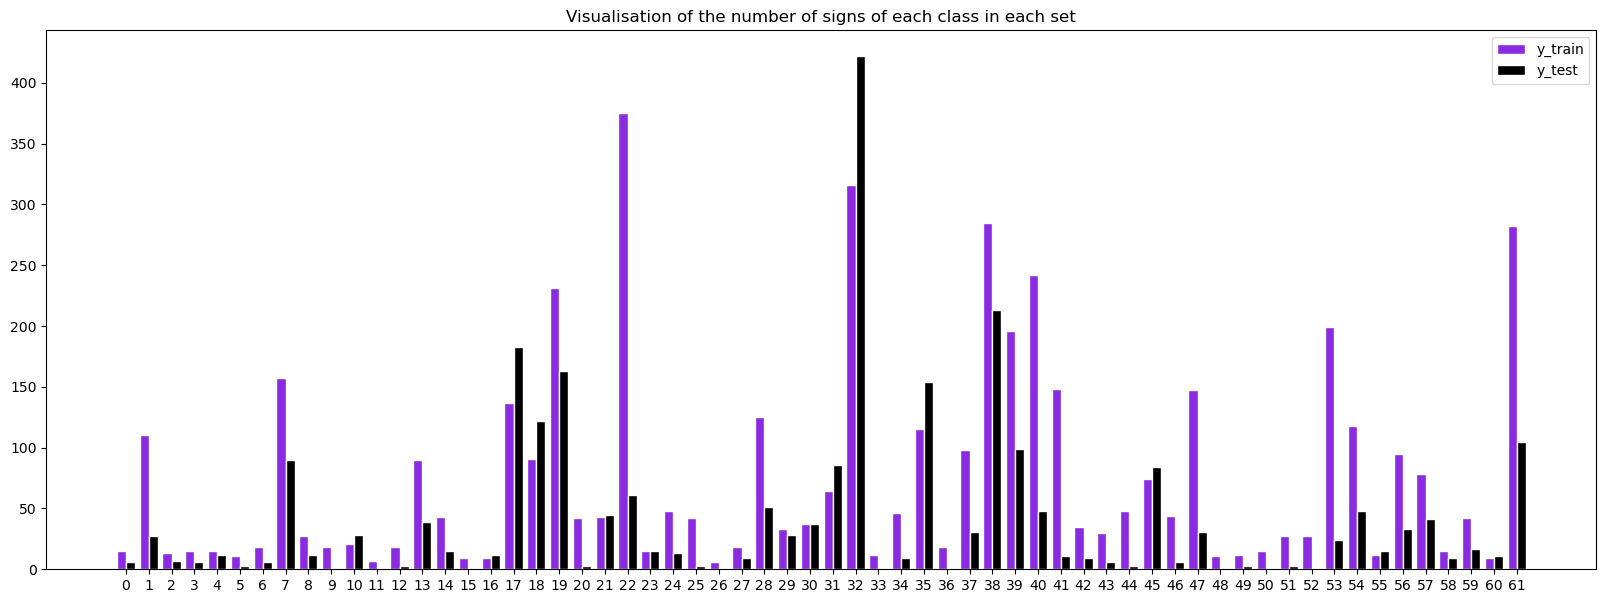

In [9]:
graphs(nbr_train_first, y_train_first)

In [10]:
from numpy import zeros, where
from tensorflow import gather  
from random import randint

# Second method of data augmentation 
# All classes are represented with the same number of sign, the max already in 

memory = zeros(nbr_class, dtype=int)
lim = max(initial_nbr_train)
counter = 0

#-----------------------------------------------------------------------------

for i in range(nbr_class) :

    memory[i] = lim - initial_nbr_train[i]
    counter += lim - initial_nbr_train[i]

#-----------------------------------------------------------------------------

# We create new sets that we'll fill with the data of the initial sets + the augmented data

X_train_second = zeros((len(X_train) + counter, resol[0], resol[1], 3))
y_train_second = zeros(len(y_train) + counter)

X_train_second[:len(X_train)] = X_train
y_train_second[:len(y_train)] = y_train

#-----------------------------------------------------------------------------

# We'll start adding values at this index

index = len(X_train)

nbr_train_second = initial_nbr_train.copy() 

#-----------------------------------------------------------------------------

for i in range(nbr_class) :

    indices = where(y_train == i)
    augmented_image = gather(augmented_image_train, indices=indices[0])

    for j in range(memory[i]) :

        idx = randint(0, len(indices[0])-1)

        nbr_train_second[i] += 1 

        X_train_second[index] = augmented_image[idx]
        y_train_second[index] = i
        index += 1

#-----------------------------------------------------------------------------

print("Shape of the augmented training set with second method : ", X_train_second.shape)
print("Shape of the augmented training target with second method : ", y_train_second.shape)

Shape of the augmented training set with second method :  (23250, 40, 30, 3)
Shape of the augmented training target with second method :  (23250,)


Number of each sign in the train set : 

[375 375 375 375 375 375 375 375 375 375 375 375 375 375 375 375 375 375
 375 375 375 375 375 375 375 375 375 375 375 375 375 375 375 375 375 375
 375 375 375 375 375 375 375 375 375 375 375 375 375 375 375 375 375 375
 375 375 375 375 375 375 375 375]

Total of signs :  23250

Number of each sign in the test set : 

[  6  27   7   6  12   3   6  90  12   0  28   0   3  39  15   0  12 183
 122 163   3  45  61  15  13   3   0   9  51  28  37  86 422   0   9 154
   0  31 213  99  48  11   9   6   3  84   6  31   0   3   0   3   0  24
  48  15  33  41   9  17  11 105]

Total of signs :  2520


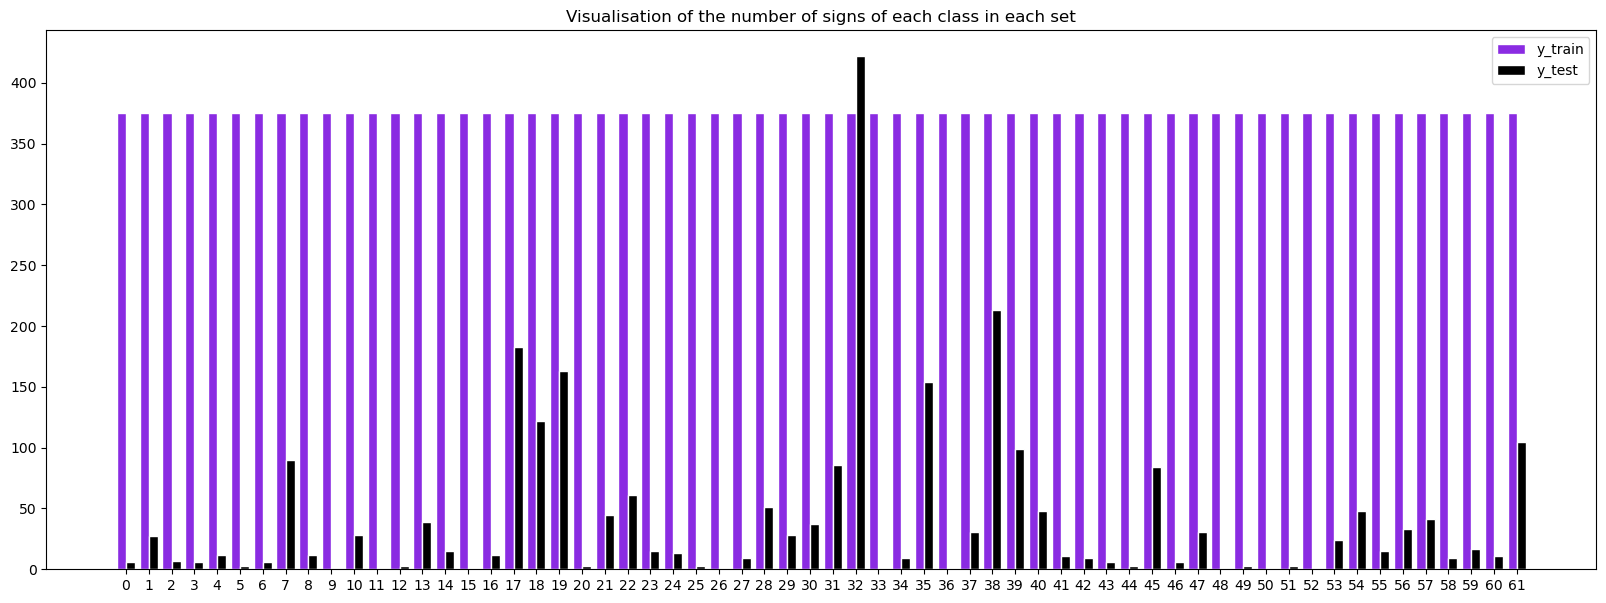

In [11]:
graphs(nbr_train_second,y_train_second )

In [12]:
from keras.utils import to_categorical

# We put our results to categorical 

# talk Some explanations needed ...

#-----------------------------------------------------------------------------

y_test_tc = to_categorical(y_test, nbr_class)
y_train_tc = to_categorical(y_train, nbr_class)

print("Shape of y_train without augmentation : ", y_train_tc.shape)
print("Shape of y_test without augmentation : ", y_test_tc.shape)

#-----------------------------------------------------------------------------

y_train_first_tc = to_categorical(y_train_first, nbr_class)


print("Shape of y_train with first method : ", y_train_first_tc.shape)
print("Shape of y_test with first method : ", y_test_tc.shape)

#-----------------------------------------------------------------------------

y_train_second_tc = to_categorical(y_train_second, nbr_class)

print("Shape of y_train with second method : ", y_train_second_tc.shape)
print("Shape of y_test with second method : ", y_test_tc.shape)

Shape of y_train without augmentation :  (4575, 62)
Shape of y_test without augmentation :  (2520, 62)
Shape of y_train with first method :  (4699, 62)
Shape of y_test with first method :  (2520, 62)
Shape of y_train with second method :  (23250, 62)
Shape of y_test with second method :  (2520, 62)


In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

def construct_model (array) : 

    # We construct our model using CNN architecture (AlexNet, LeNet)

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape = array.shape[1:]) )
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(nbr_class, activation='softmax'))

    #Compilation of the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [14]:
model_simple = construct_model(X_train)
model_simple.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 36, 26, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 22, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 11, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 11, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 9, 64)         18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 7, 64)         36928     
                                                      

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

# We train here the model with the first method of augmentation 

eps = 5 # The number of time we want the model to train on the entire training_set

#-----------------------------------------------------------------------------

mycallbacks = [EarlyStopping(monitor='val_loss', patience=5)]

#-----------------------------------------------------------------------------

validation_X_simple = X_test.copy()
validation_y_simple = y_test_tc.copy()

simple_X = X_train.copy() 
simple_y = y_train_tc.copy() 

#-----------------------------------------------------------------------------

anc_simple = model_simple.fit(simple_X, simple_y,validation_data=(validation_X_simple,validation_y_simple), epochs=eps, callbacks=mycallbacks)

#-----------------------------------------------------------------------------

#added aug.flow to (X_train, y_train) to do data augmentation
# validation_data=(X_test_new_first, y_test_new_first)
# validation_data=(X_test, y_test)

# talk : aug.flow ? 
# talk : validation data strange 

Epoch 1/5
143/143 [==============================] - 38s 228ms/step - loss: 4.6652 - accuracy: 0.2846 - val_loss: 1.7364 - val_accuracy: 0.6595
Epoch 2/5
143/143 [==============================] - 28s 197ms/step - loss: 1.5546 - accuracy: 0.6400 - val_loss: 0.5941 - val_accuracy: 0.8706
Epoch 3/5
143/143 [==============================] - 38s 265ms/step - loss: 0.8813 - accuracy: 0.7836 - val_loss: 0.3944 - val_accuracy: 0.9044
Epoch 4/5
143/143 [==============================] - 18s 125ms/step - loss: 0.6170 - accuracy: 0.8433 - val_loss: 0.3219 - val_accuracy: 0.9278
Epoch 5/5
143/143 [==============================] - 19s 131ms/step - loss: 0.4890 - accuracy: 0.8739 - val_loss: 0.2256 - val_accuracy: 0.9460


In [16]:
from matplotlib.pyplot import figure, subplot, plot, title, xlabel, ylabel, legend, tight_layout, show

def perf(anc) : 

    # Plot of performances 

    figure()

    subplot(2, 1, 1)
    plot(anc.history['accuracy'], label='training accuracy', color = 'darkblue')
    plot(anc.history['val_accuracy'], label='test accuracy', color = 'magenta')
    title('Accuracy')
    xlabel('epochs')
    ylabel('accuracy')
    legend()

    subplot(2, 1, 2)
    plot(anc.history['loss'], label='training loss', color = 'darkblue')
    plot(anc.history['val_loss'], label='test loss', color = 'magenta')
    title('Loss')
    xlabel('epochs')
    ylabel('loss')
    legend()

    tight_layout()
    show()

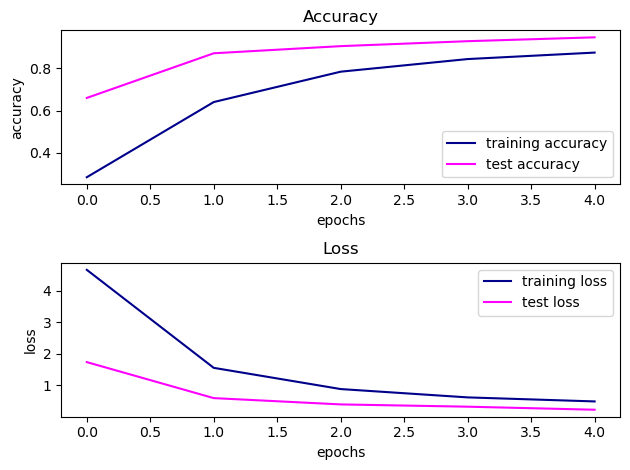

In [17]:
perf(anc_simple)

In [18]:
label_names = open("dict.csv").read().strip().split("\n")[0:]
label_names = [l.split(",")[1] for l in label_names]

In [19]:
from sklearn.metrics import classification_report

# Evaluate the network

print("[INFO] evaluating network...")
predictions_simple = model_simple .predict(X_test) 
print(classification_report(y_test_tc.argmax(axis=1),
	predictions_simple.argmax(axis=1), target_names=label_names, labels=range(nbr_class)))

[INFO] evaluating network...
79/79 [==============================] - 2s 23ms/step
                                 precision    recall  f1-score   support

               "uneven_surface"       1.00      1.00      1.00         6
                         "bump"       0.82      1.00      0.90        27
                     "slippery"       0.88      1.00      0.93         7
                   "left_curve"       1.00      0.83      0.91         6
                  "right_curve"       0.92      0.92      0.92        12
                  "left_curves"       0.75      1.00      0.86         3
                 "right_curves"       1.00      1.00      1.00         6
                     "children"       0.99      0.99      0.99        90
                      "cyclist"       0.82      0.75      0.78        12
                      "animals"       0.00      0.00      0.00         0
                    "roadworks"       0.91      0.75      0.82        28
              "traffic_signals"       0.

d:\Documents\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Documents\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Documents\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Documents\Anaconda\lib\site-packages\sklearn\metrics\_classification.

In [20]:
# Here's a function that will give the score that we can see on kaggle 

true = y_test_tc.argmax(axis=1)

print("True codes : ", true)
print("Number of true codes : ", len(true))

predict = model_simple.predict(X_test).argmax(axis=1)

print("Predictions : ", predict)
print("Number of predictions : ", len(predict))

right = 0 

for i in range(len(true)) : 
    if predict[i] == true[i] :  
        right += 1 

print("Number of right : ", right)
print("Number of elements : ", len(true))

print("Ratio : ", right/len(true))

True codes :  [ 0  0  0 ... 61 61 61]
Number of true codes :  2520
79/79 [==============================] - 2s 23ms/step
Predictions :  [ 0  0  0 ... 61 61 61]
Number of predictions :  2520
Number of right :  2384
Number of elements :  2520
Ratio :  0.946031746031746


In [22]:
model_first = construct_model(X_train_first)
model_first.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 36, 26, 32)        2432      
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 22, 32)        25632     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 11, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 16, 11, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 9, 64)         18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 7, 64)         36928     
                                                      

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

# We train here the model with the first method of augmentation 

eps = 5 # The number of time we want the model to train on the entire training_set

#-----------------------------------------------------------------------------

mycallbacks = [EarlyStopping(monitor='val_loss', patience=5)]

#-----------------------------------------------------------------------------

validation_X_first = X_test.copy()
validation_y_first = y_test_tc.copy()

#-----------------------------------------------------------------------------

anc_first = model_first.fit(X_train_first, y_train_first_tc,validation_data=(validation_X_first,validation_y_first), epochs=eps, callbacks=mycallbacks)

#-----------------------------------------------------------------------------

#added aug.flow to (X_train, y_train) to do data augmentation
# validation_data=(X_test_new_first, y_test_new_first)
# validation_data=(X_test, y_test)

# talk : aug.flow ? 
# talk : validation data strange 

Epoch 1/5
147/147 [==============================] - 21s 125ms/step - loss: 3.3936 - accuracy: 0.3277 - val_loss: 1.3821 - val_accuracy: 0.7278
Epoch 2/5
147/147 [==============================] - 19s 131ms/step - loss: 1.3973 - accuracy: 0.6727 - val_loss: 0.6036 - val_accuracy: 0.8873
Epoch 3/5
147/147 [==============================] - 20s 135ms/step - loss: 0.8452 - accuracy: 0.7997 - val_loss: 0.4515 - val_accuracy: 0.8956
Epoch 4/5
147/147 [==============================] - 22s 151ms/step - loss: 0.5982 - accuracy: 0.8461 - val_loss: 0.2572 - val_accuracy: 0.9421
Epoch 5/5
147/147 [==============================] - 22s 150ms/step - loss: 0.4724 - accuracy: 0.8772 - val_loss: 0.2141 - val_accuracy: 0.9468


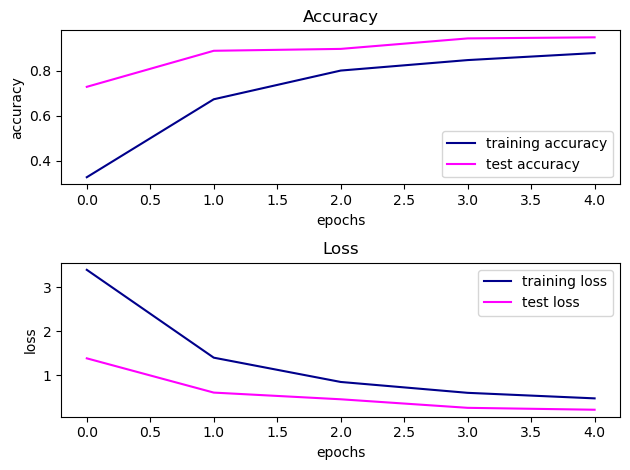

In [24]:
perf(anc_first)

In [25]:
# Here's a function that will give the score that we can see on kaggle 

true = y_test_tc.argmax(axis=1)

print("True codes : ", true)
print("Number of true codes : ", len(true))

predict = model_first.predict(X_test).argmax(axis=1)

print("Predictions : ", predict)
print("Number of predictions : ", len(predict))

right = 0 

for i in range(len(true)) : 
    if predict[i] == true[i] :  
        right += 1 

print("Number of right : ", right)
print("Number of elements : ", len(true))

print("Ratio : ", right/len(true))

True codes :  [ 0  0  0 ... 61 61 61]
Number of true codes :  2520
79/79 [==============================] - 3s 31ms/step
Predictions :  [ 0  0  0 ... 61 61 61]
Number of predictions :  2520
Number of right :  2386
Number of elements :  2520
Ratio :  0.9468253968253968


In [26]:
from sklearn.metrics import classification_report

# Evaluate the network

print("[INFO] evaluating network...")
predictions_first = model_first.predict(X_test) 
print(classification_report(y_test_tc.argmax(axis=1),
	predictions_first.argmax(axis=1), target_names=label_names, labels=range(nbr_class)))

[INFO] evaluating network...
79/79 [==============================] - 2s 28ms/step
                                 precision    recall  f1-score   support

               "uneven_surface"       0.86      1.00      0.92         6
                         "bump"       0.87      1.00      0.93        27
                     "slippery"       1.00      0.43      0.60         7
                   "left_curve"       0.50      0.83      0.62         6
                  "right_curve"       0.75      0.50      0.60        12
                  "left_curves"       0.00      0.00      0.00         3
                 "right_curves"       0.60      1.00      0.75         6
                     "children"       0.98      0.98      0.98        90
                      "cyclist"       0.79      0.92      0.85        12
                      "animals"       0.00      0.00      0.00         0
                    "roadworks"       1.00      0.75      0.86        28
              "traffic_signals"       0.

d:\Documents\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Documents\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Documents\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Documents\Anaconda\lib\site-packages\sklearn\metrics\_classification.

In [27]:
model_second = construct_model(X_train_second)
model_second.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 36, 26, 32)        2432      
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 22, 32)        25632     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 11, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 16, 11, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 9, 64)         18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 12, 7, 64)         36928     
                                                      

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

# We train here the model with the first method of augmentation 

eps = 5 # The number of time we want the model to train on the entire training_set

#-----------------------------------------------------------------------------

mycallbacks = [EarlyStopping(monitor='val_loss', patience=5)]

#-----------------------------------------------------------------------------

validation_X_second = X_test.copy()
validation_y_second = y_test_tc.copy()

#-----------------------------------------------------------------------------

anc_second = model_second.fit(X_train_second, y_train_second_tc,validation_data=(validation_X_second,validation_y_second), epochs=eps, callbacks=mycallbacks)

#-----------------------------------------------------------------------------

#added aug.flow to (X_train, y_train) to do data augmentation
# validation_data=(X_test_new_first, y_test_new_first)
# validation_data=(X_test, y_test)

# talk : aug.flow ? 
# talk : validation data strange 

Epoch 1/5
727/727 [==============================] - 101s 137ms/step - loss: 3.0159 - accuracy: 0.2602 - val_loss: 1.0997 - val_accuracy: 0.7286
Epoch 2/5
727/727 [==============================] - 92s 126ms/step - loss: 1.3848 - accuracy: 0.5940 - val_loss: 0.6577 - val_accuracy: 0.8361
Epoch 3/5
727/727 [==============================] - 88s 121ms/step - loss: 0.9789 - accuracy: 0.7105 - val_loss: 0.5776 - val_accuracy: 0.8480
Epoch 4/5
727/727 [==============================] - 87s 120ms/step - loss: 0.7630 - accuracy: 0.7698 - val_loss: 0.4461 - val_accuracy: 0.8889
Epoch 5/5
727/727 [==============================] - 87s 120ms/step - loss: 0.6594 - accuracy: 0.7971 - val_loss: 0.3774 - val_accuracy: 0.9067


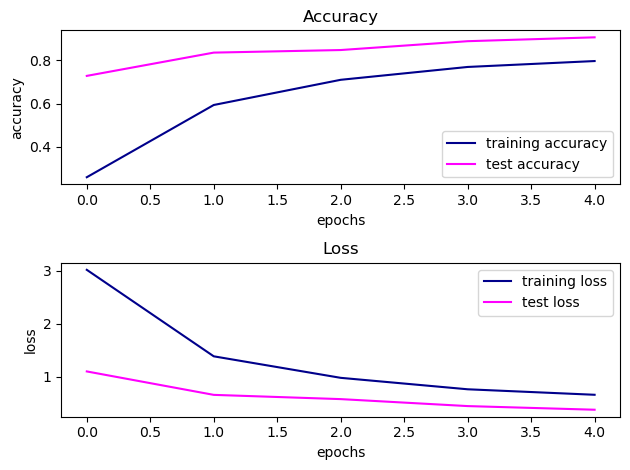

In [29]:
perf(anc_second)

In [30]:
# Here's a function that will give the score that we can see on kaggle 

true = y_test_tc.argmax(axis=1)

print("True codes : ", true)
print("Number of true codes : ", len(true))

predict = model_second.predict(X_test).argmax(axis=1)

print("Predictions : ", predict)
print("Number of predictions : ", len(predict))

right = 0 

for i in range(len(true)) : 
    if predict[i] == true[i] :  
        right += 1 

print("Number of right : ", right)
print("Number of elements : ", len(true))

print("Ratio : ", right/len(true))

True codes :  [ 0  0  0 ... 61 61 61]
Number of true codes :  2520
79/79 [==============================] - 2s 28ms/step
Predictions :  [ 1  1  0 ... 61 61 61]
Number of predictions :  2520
Number of right :  2285
Number of elements :  2520
Ratio :  0.9067460317460317


In [31]:
from sklearn.metrics import classification_report

# Evaluate the network

print("[INFO] evaluating network...")
predictions_second = model_second.predict(X_test) 
print(classification_report(y_test_tc.argmax(axis=1),
	predictions_second.argmax(axis=1), target_names=label_names, labels=range(nbr_class)))

[INFO] evaluating network...
79/79 [==============================] - 3s 32ms/step
                                 precision    recall  f1-score   support

               "uneven_surface"       1.00      0.17      0.29         6
                         "bump"       0.66      1.00      0.79        27
                     "slippery"       0.86      0.86      0.86         7
                   "left_curve"       0.00      0.00      0.00         6
                  "right_curve"       1.00      0.75      0.86        12
                  "left_curves"       0.75      1.00      0.86         3
                 "right_curves"       0.83      0.83      0.83         6
                     "children"       0.77      0.99      0.86        90
                      "cyclist"       0.40      0.33      0.36        12
                      "animals"       0.00      0.00      0.00         0
                    "roadworks"       1.00      0.75      0.86        28
              "traffic_signals"       0.

d:\Documents\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Documents\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Documents\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Documents\Anaconda\lib\site-packages\sklearn\metrics\_classification.

In [32]:
from os import listdir
from numpy import asarray, append, array

# We store all of the images from the kaggle folder in an array 
# recall that target has been defined above 

images = [] 
names = []

# get the path/directory
folder_dir = 'eval_kaggle1'

for image in listdir(folder_dir):
    # check if the image ends with ppm
    if (image.endswith(".ppm")):
        img = Image.open(folder_dir + '/' + image)
        img = img.resize(resol) # (30,30) as an example 
        img = asarray(img)
        images.append(img) 
        names.append(image.replace('.ppm',''))

images = array(images)

print("Number of images and their resolution in the kaggle dataset : ", images.shape)

Number of images and their resolution in the kaggle dataset :  (202, 30, 40, 3)


In [33]:
# Here is a code to save all ppm in jpeg in a directory called names (must be created)

# get the path/directory
folder_dir = "eval_kaggle1"

for image in listdir(folder_dir):
    # check if the image ends with ppm
    if (image.endswith(".ppm")):
        img = Image.open(folder_dir + '/' + image)
        img.save("names" + '/' + image.replace('.ppm','.jpg'), format = 'JPEG') 

In [34]:
from csv import DictReader

# We will store the data in dict.csv in a dict 

data = {}

with open('dict.csv', 'r') as f:
    d_reader = DictReader(f, fieldnames=["num", "sign"])

    #get fieldnames from DictReader object and store in list
    for row in d_reader:
        data[row['num']] = row['sign']


7/7 [==============================] - 0s 37ms/step


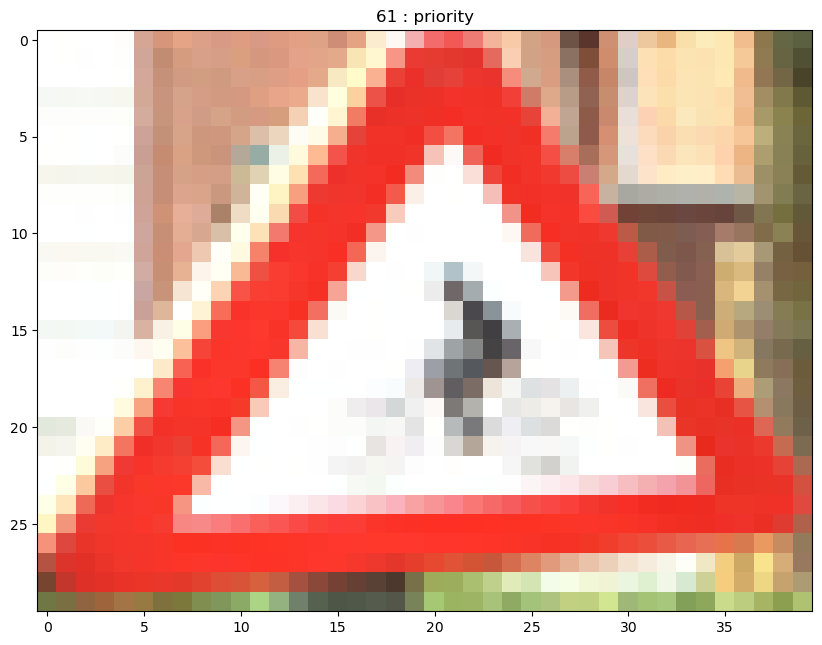

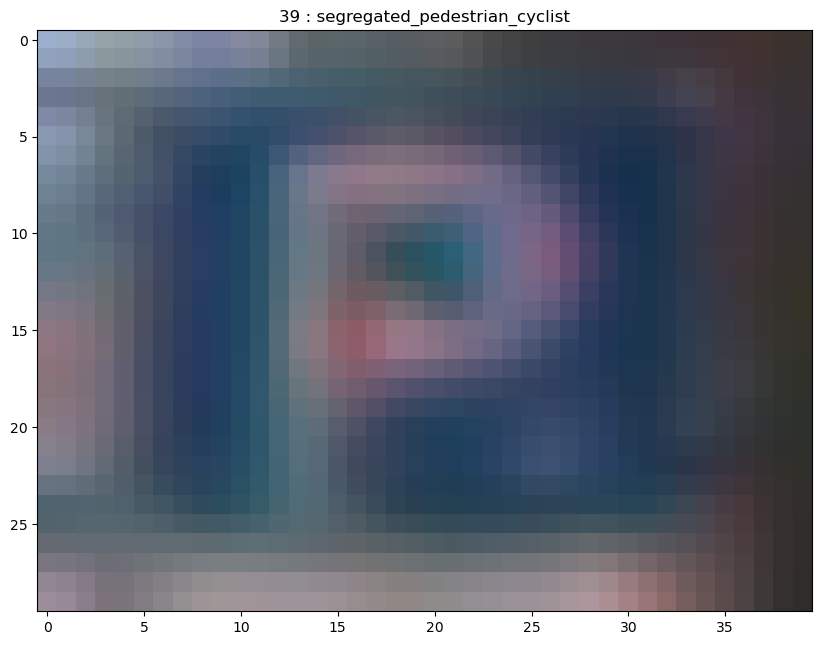

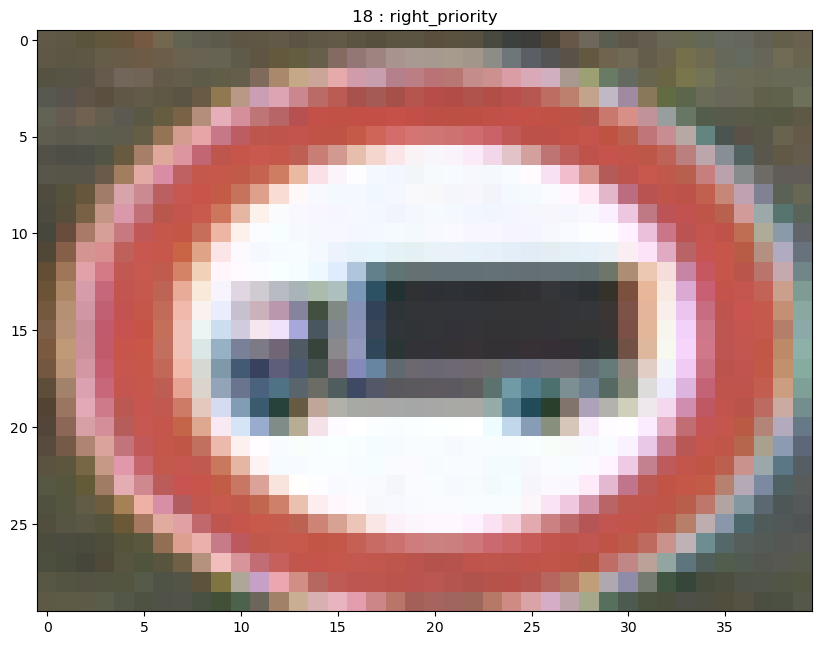

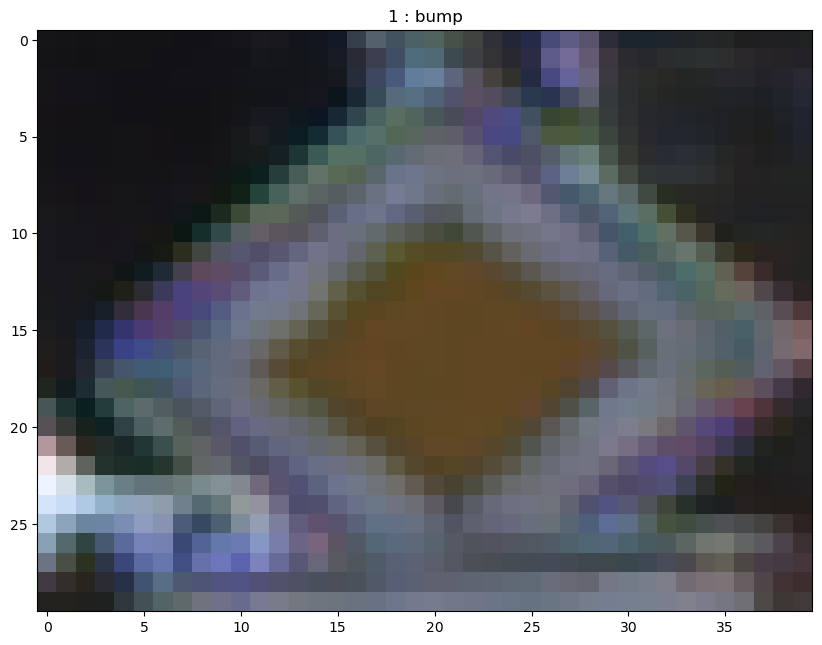

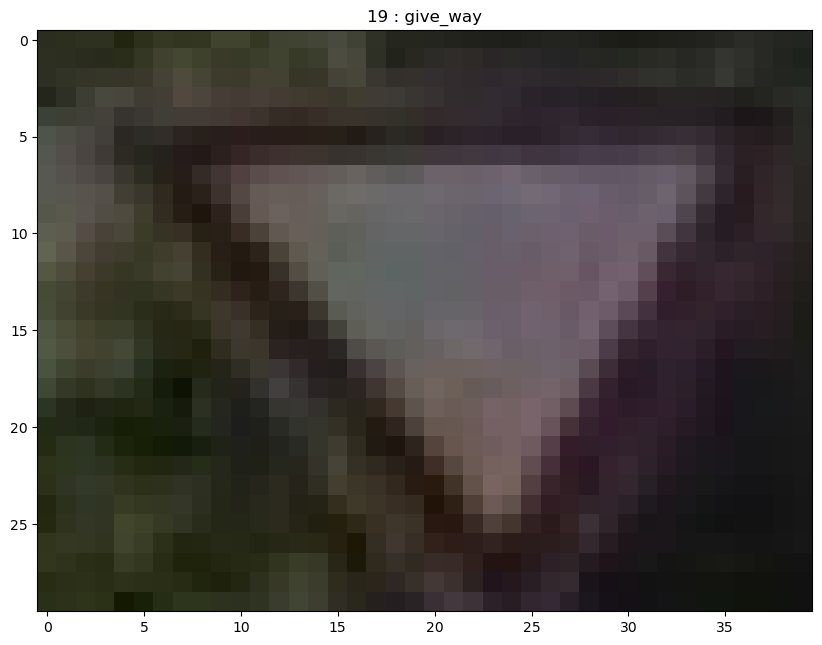

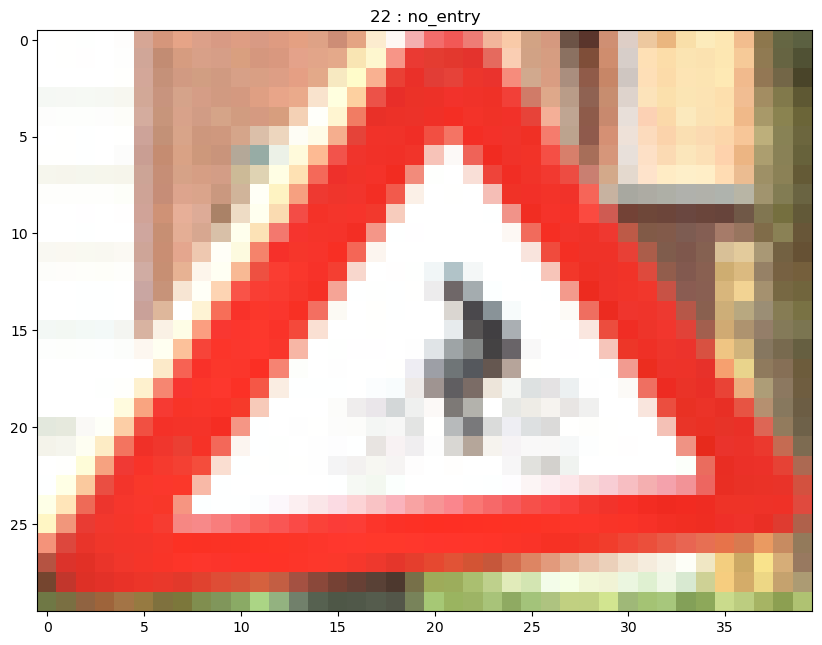

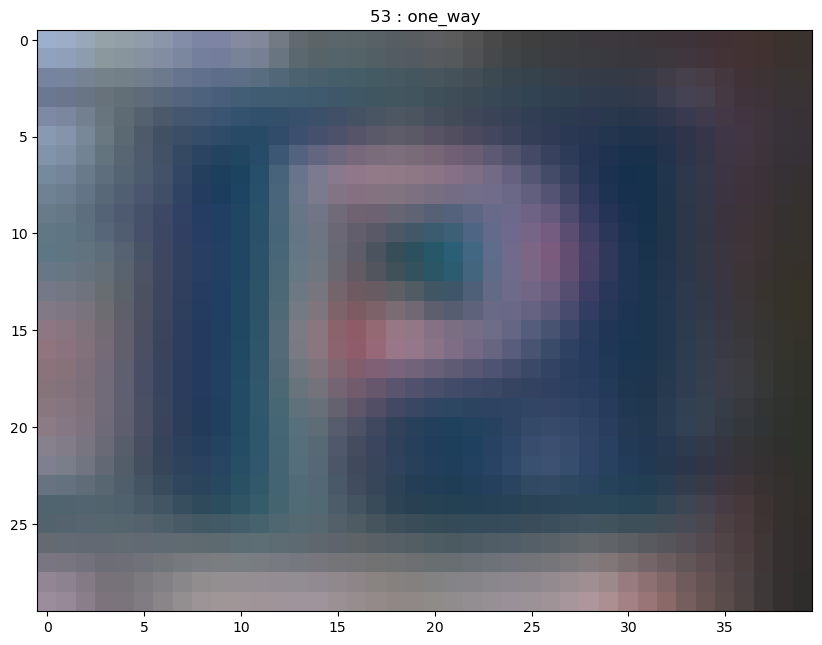

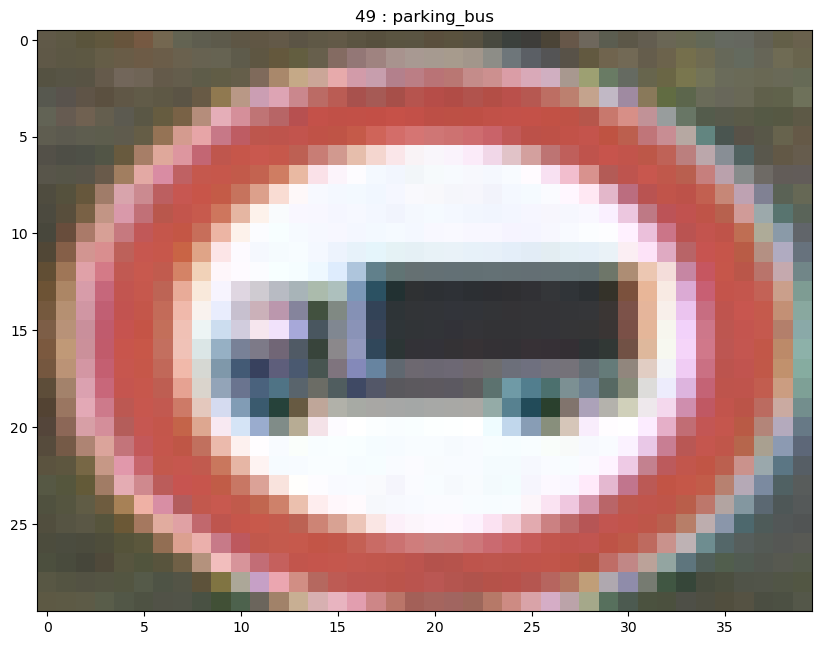

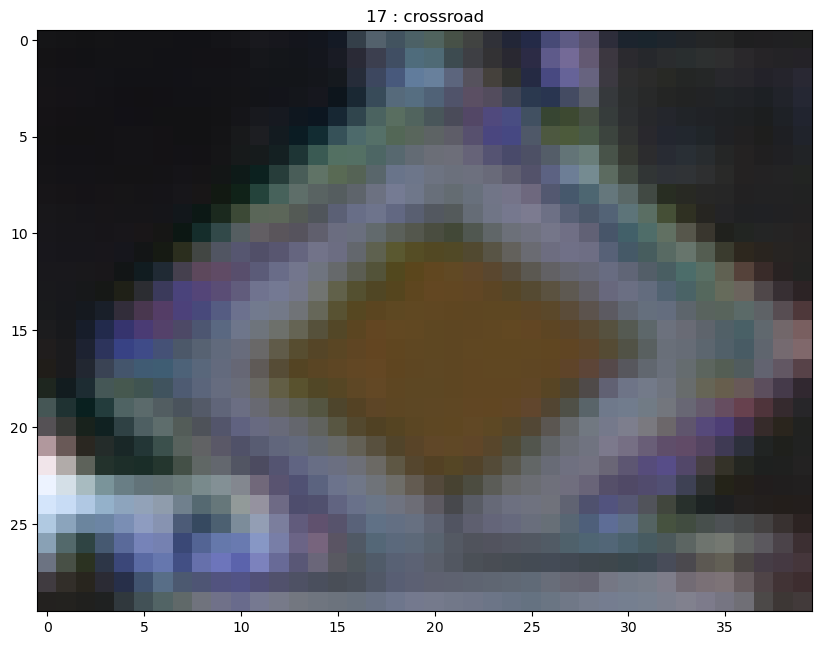

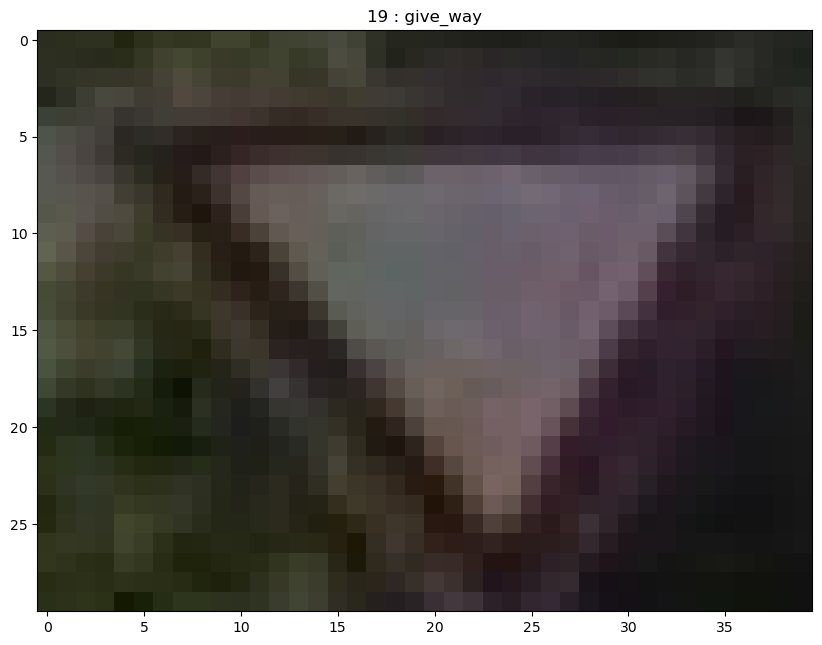

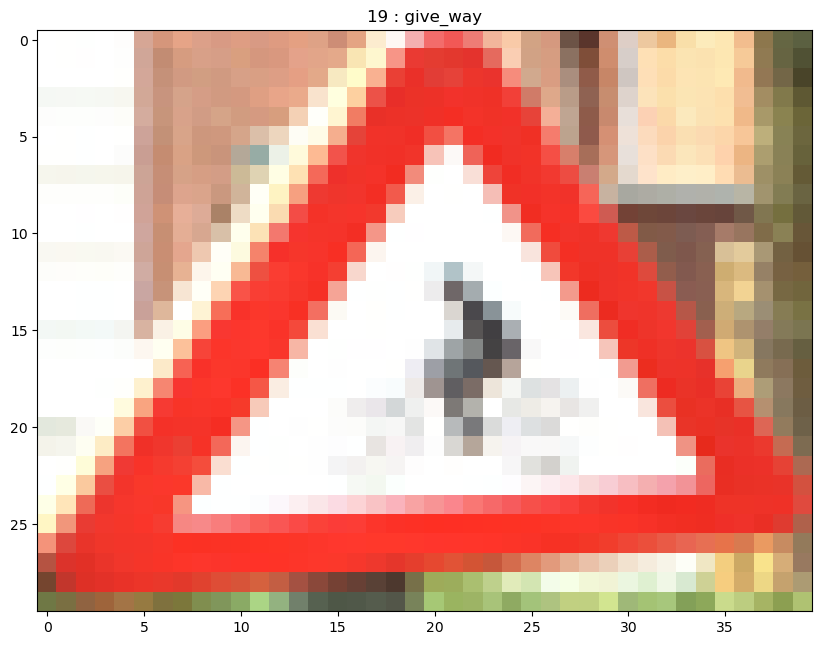

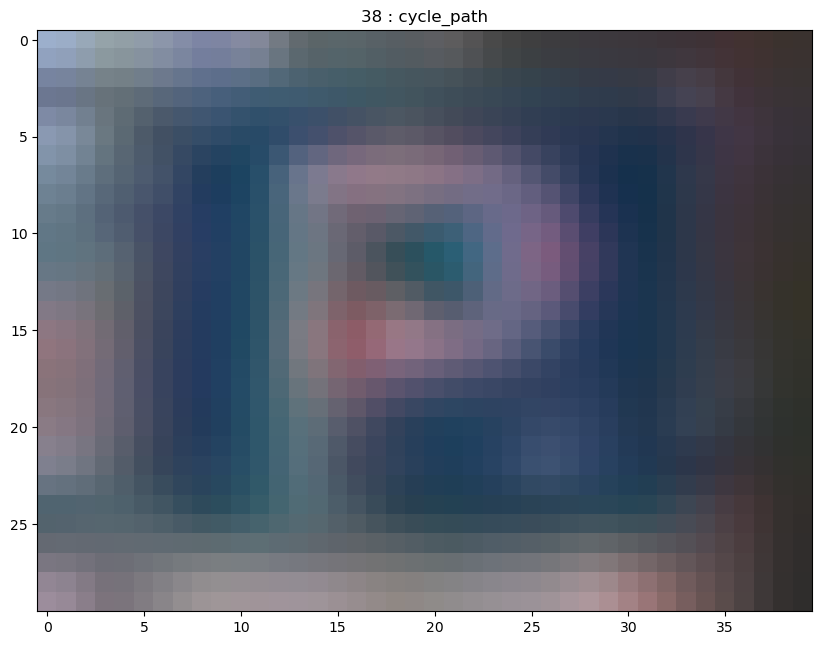

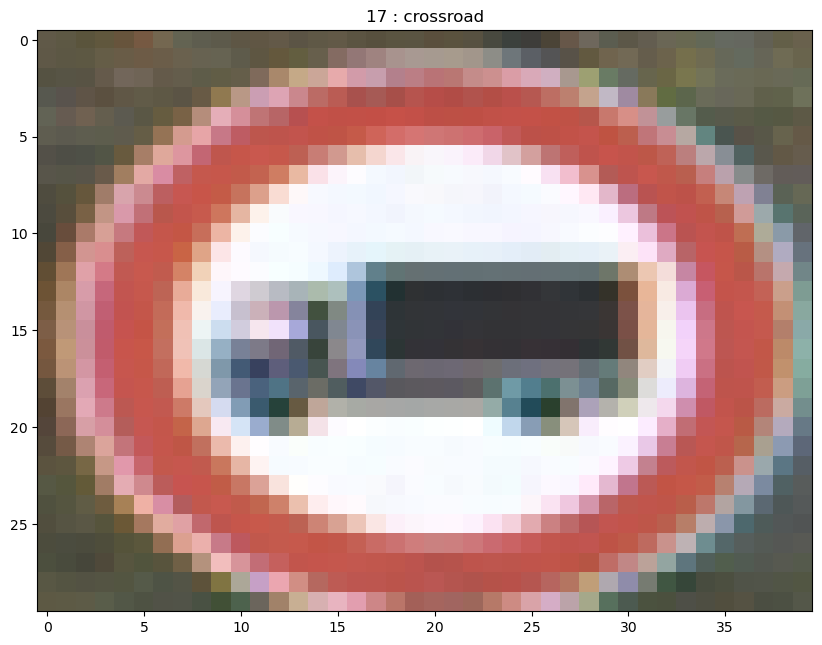

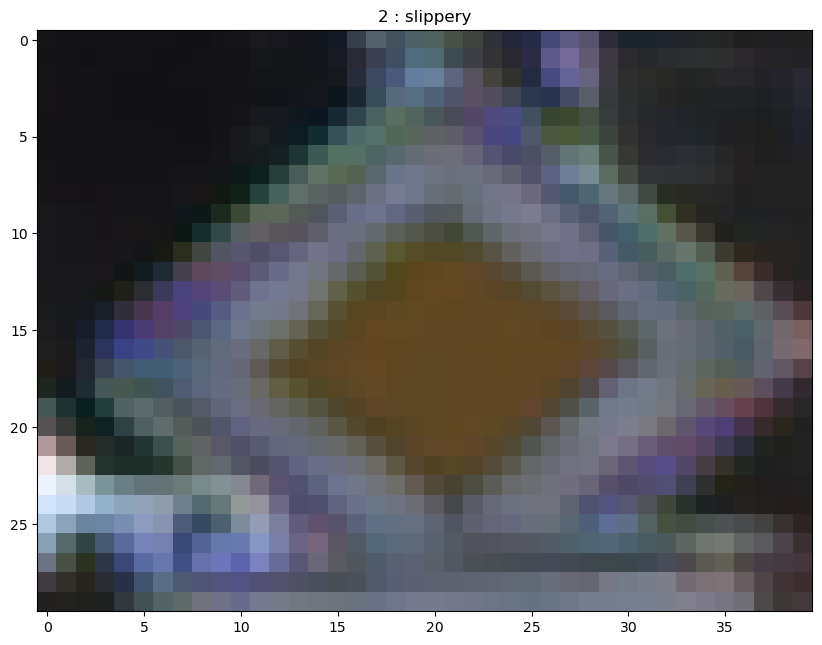

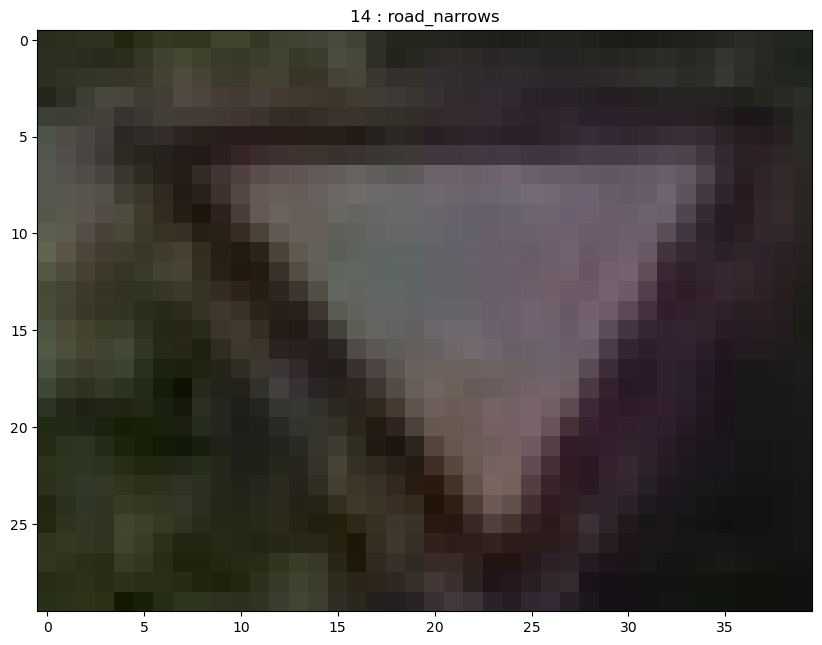

In [35]:
from matplotlib.pyplot import figure, show, title, imshow 
from csv import DictWriter

models = [model_simple, model_first, model_second] 

# We then print the image with num and the sign predicted as a title 

count = 0 
for model in models : 

    predictions = model.predict(images).argmax(axis=1) 
 
    for i in range(5): 
        figure(figsize = (10,10))
        imshow(images[i])
        sign = data[str(predictions[i])]
        title(str(predictions[i]) + " : " + str(sign))

    # Here is the code to write the results in a CSV for kaggle 

    with open('final_' + str(count) + '.csv', 'w', newline='') as csvfile:
        fieldnames = ['Id', 'Category']
        writer = DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for i in range(len(predictions)): 
            writer.writerow({'Id' : names[i], 'Category' : predictions[i]})

    count += 1 